# Impute raw AOD from MODIS
for 3D array (timeseries)      
- combine AOD from Aqua and Terra on means
- impute missing values with Lettice Krigging

## **Purpose:**
##### To create a nD array without NAN's in suitable format for further analysis (NumPy)    

## **Outcome:**
##### NumPy 4D array for AOD timeseries
shape(7305,31,51) of (time, long, lat)     

## **Steps:**  
- [x] import MOD and MYD arrays
- [x] check the percentage of NAN's     
- [x] take mean between MOD and MYD 
- [x] check the percentage of NAN's again  
- [x] impute missing values
- [x] limit to realistic AOD
- [x] plot results 
- [x] save as NumPy array


In [1]:
# Import libraries

# Handle NumPy arrays
import numpy as np
import math

# Imputation libraries
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg
from scipy import stats

# Additional packages for plots
import matplotlib.pyplot as plt

# Plotting & display options
%matplotlib inline

In [2]:
# Check your working directory
%pwd

'/Users/scib/Desktop/CDT_data_laads/2002-2022_all'

In [3]:
# If necessary, use %cd to navigate to a folder containg your files
%cd /Users/scib/Downloads/pre_processed_data/

/Users/scib/Downloads/pre_processed_data


## Join raw MOD and MYD (by mean value)

In [4]:
# Import AOD data

# MYD array (Aqua)
myd_arr = np.load('1_AOD_myd.npy')

# MOD array (Terra)
mod_arr = np.load('2_AOD_mod.npy')

In [8]:
# Ensure arrays are equal 
assert( np.array_equal( len(myd_arr[:,:,:]), len(mod_arr[:,:,:]), equal_nan=True))

In [7]:
# Check array shape
print(np.shape(mod_arr))

(7305, 31, 51)


In [9]:
# Calculate number of NAN's for Aqua MYD
# % of missing values in array
my_MYD_nans = []
for j in range(len(myd_arr)):
    jj = np.isnan(myd_arr[j]).sum()
    my_MYD_nans.append(jj)

# Calculate percentage of missing values
my_MYD_nans_sum = np.sum(my_MYD_nans)
print(f'Aqua MYD array has:', my_MYD_nans_sum,"nans")
print(f'Percentage of NANs:', my_MYD_nans_sum/(np.prod(np.shape(myd_arr)))*100,'%')

Aqua MYD array has: 3789342 nans
Percentage of NANs: 32.81041422331667 %


In [10]:
# Calculate number of NAN's for Terra MOD
# % of missing values in array
my_MOD_nans = []
for j in range(len(mod_arr)):
    jj = np.isnan(mod_arr[j]).sum()
    my_MOD_nans.append(jj)

# Calculate percentage of missing values
my_MOD_nans_sum = np.sum(my_MOD_nans)
print(f'Terra MOD array has:', my_MOD_nans_sum,"nans")
print(f'Percentage of NANs:', my_MOD_nans_sum/(np.prod(np.shape(mod_arr)))*100,'%')

Terra MOD array has: 3567351 nans
Percentage of NANs: 30.88828192070363 %


### Take mean between MOD and MYD

In [11]:
# Mean with NAN's along time axis
aod_mean = np.nanmean(np.array([myd_arr, mod_arr]), axis=0)
# Check the shape
aod_mean.shape

/var/folders/jv/tnxcldt97xn41qcfjsjyzlkm0000gn/T/ipykernel_17340/948948355.py:2: RuntimeWarning: Mean of empty slice
  aod_mean = np.nanmean(np.array([myd_arr, mod_arr]), axis=0)


(7305, 31, 51)

In [12]:
# Calculate % of NAN's in joint AOD array
my_AOD_nans = []
for j in range(len(aod_mean)):
    jj = np.isnan(aod_mean[j]).sum()
    my_AOD_nans.append(jj)

# Calculate percentage of missing values
my_AOD_nans_sum = np.sum(my_AOD_nans)
print(f'AOD mean array has:', my_AOD_nans_sum,"nans")
print(f'Percentage of NANs:', my_AOD_nans_sum/(np.prod(np.shape(aod_mean)))*100,'%')

AOD mean array has: 2296826 nans
Percentage of NANs: 19.887308260611878 %


### Impute missing values

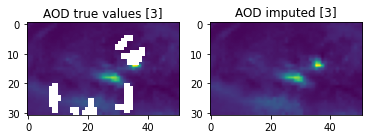

CPU times: user 1min 27s, sys: 1.53 s, total: 1min 29s
Wall time: 1min 29s


In [14]:
%%time 
# 👆🏽 display imputaion time (~1min30s)

# Impute missing values for mean AOD

# Get image size
nx = aod_mean.shape[2] # columns
ny = aod_mean.shape[1] # rows

# Set up precision matrix for Gaussian Processes model
Bx = 0.25*sp.diags([np.repeat(-1, nx-1),
                    np.repeat([1, 2, 1], [1, nx-2, 1]),
                    np.repeat(-1, nx-1)],
                   [-1, 0, 1])
By = 0.25*sp.diags([np.repeat(-1, ny-1),
                    np.repeat([1, 2, 1], [1, ny-2, 1]),
                    np.repeat(-1, ny-1)],
                   [-1, 0, 1])
lx = sp.eye(nx)
ly = sp.eye(ny)

# Calculate kronecker product of sparse array
DD = sp.kron(lx, By) + sp.kron(Bx.T, ly)

# Calculate dot product & convert to compressed sparse column
RR = DD.dot(DD.T @ DD).tocsc()

# Set value of hyperparameter kappa
kappa = 0.1980

# Empty array for imputed AOD
aod_imputed = []

# Loop over 3D array 
for jj in range(len(aod_mean)):
    
    # Vectorise the matrix by column stacking
    aod_vec = aod_mean[jj].transpose().reshape((-1))
    
    # Calculate incidence matrix AA
    # (extract non-missing elemnts from aod_vec)
    colsA = np.where(~np.isnan(aod_vec))[0]
    rowsA = np.arange(len(colsA))
    valsA = np.ones(len(colsA))
    shapeA = (len(colsA), len(aod_vec))
    AA = sp.csr_matrix((valsA, (rowsA, colsA)), shapeA)

    # Calculate conditional expectation of missing values given the non-missing values
    aod_vec_infered = sp.linalg.spsolve(kappa * RR + AA.T @ AA, AA.T @ AA @ aod_vec)
    
    # Retain original aod values 
    aod_vec_imputed = aod_vec.copy()
    i_nan = np.where(np.isnan(aod_vec))
    
    # Replace with imputation only missing values 
    aod_vec_imputed[i_nan] = aod_vec_infered[i_nan]

    # Reshape back to 2D grids
    aod_imputed_2d = aod_vec_imputed.reshape((nx,ny)).T

    # Save imputed values
    aod_imputed.append(aod_imputed_2d)


## Plot example array of results side by side
# Choose index example number to plot
aod_idx = 3

# AOD mean
plt.subplot(121)
plt.imshow(aod_mean[aod_idx])
plt.title("AOD true values [%s]" % aod_idx)
# AOD imputed
plt.subplot(122)
plt.imshow(aod_imputed[aod_idx])
plt.title("AOD imputed [%s]" % aod_idx)

plt.show()

In [15]:
np.shape(aod_imputed)

(7305, 31, 51)

## Limit values to realistic
AOD can only take values between 0 to 5 <br>
0 ≤AOD≥ 5 <br>
- Use the min from `aod_true` = 0.0000000000001 <br>
- Use the max from `aod_true` = 5.0000000000000 <br>

In [16]:
# Print min and max of true values
print('MYD MAX:', np.nanmax(myd_arr))
print('MYD MIN:', np.nanmin(myd_arr))

MYD MAX: 5.0000002374872565
MYD MIN: -0.050000002374872565


In [17]:
# Print min and max for imputed values
print('MYD MAX:', np.nanmax(aod_imputed))
print('MYD MIN:', np.nanmin(aod_imputed))

MYD MAX: 8.863859436493064
MYD MIN: -6.175216316633388


In [18]:
# Set limits
ul = 5.0000000000000 # upper limit
bl = 0.0000000000001 # bottom limit

# Save limited values in new array
aod_imputed_lim = []
for kk in range(len(aod_imputed)):
                limited = aod_imputed[kk].copy()
                limited[limited>=5] = ul
                limited[limited<0] = bl
                aod_imputed_lim.append(limited)

In [19]:
print(np.shape(aod_imputed_lim))

(7305, 31, 51)


In [22]:
%matplotlib inline

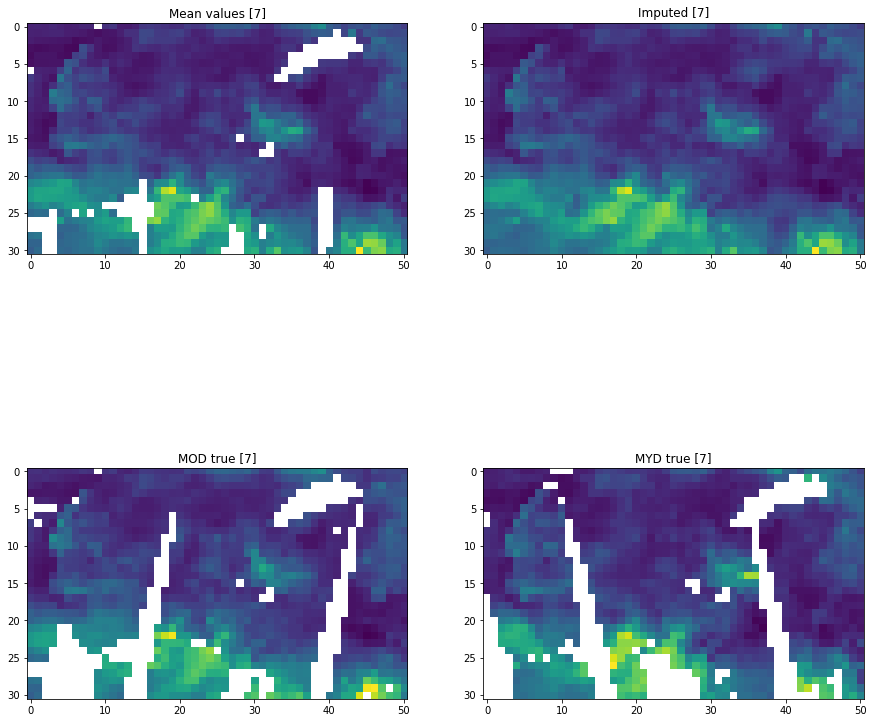

In [23]:
### Plot results

# Plot raw vs mean vs imputed values for chosen example array 

# Choose array to plot 
aod_ind = 7

# Mean AOD
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(aod_mean[aod_ind])
plt.title("Mean values [%s]" % aod_ind)

# Imputed AOD
plt.subplot(222)
plt.imshow(aod_imputed_lim[aod_ind])
plt.title("Imputed [%s]" % aod_ind)

# Raw Terra AOD
plt.subplot(223)
plt.imshow(mod_arr[aod_ind])
plt.title("MOD true [%s]" % aod_ind)

# Raw Aqua AOD
plt.subplot(224)
plt.imshow(myd_arr[aod_ind])
plt.title("MYD true [%s]" %aod_ind)

plt.show()

In [24]:
# Convert to nd array
aod_imp_lim = np.asanyarray(aod_imputed_lim)
aod_imp_lim.shape

(7305, 31, 51)

In [186]:
# Save results
np.save('AOD_imputed.npy', aod_imp_lim)